# Advanced Models & Hyperparameter Tuning – House Rent Prediction

### 1. This notebook builds on the previous baseline model and focuses on:

1. Evaluating models using **cross-validation** instead of a single train/test split.
2. Training an **advanced gradient boosting model (XGBoost)**.
3. Performing **hyperparameter tuning** with `RandomizedSearchCV`.
4. Comparing the performance of:
   - Baseline Random Forest model  
   - Tuned XGBoost model  

The goal is to demonstrate a more **realistic, production-style modeling process** suitable for data science roles.


### 2. Imports & data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

In [2]:
data_path = "data/House_Rent_Dataset.csv"
df = pd.read_csv(data_path)

print("Shape:", df.shape)
df.head()


Shape: (4746, 12)


,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


### 3. Features, target, and preprocessing

In [3]:
target_col = "Rent"

feature_cols = [
    "Size",
    "BHK",
    "Bathroom",
    "City",
    "Area Type",
    "Furnishing Status",
    "Tenant Preferred"
]

df_model = df[feature_cols + [target_col]].copy()

X = df_model[feature_cols]
y = df_model[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((3796, 7), (950, 7))

In [4]:
numeric_features = ["Size", "BHK", "Bathroom"]
categorical_features = ["City", "Area Type", "Furnishing Status", "Tenant Preferred"]

numeric_transformer = "passthrough"

categorical_transformer = OneHotEncoder(
    handle_unknown="ignore",
    sparse_output=False
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


### 4. Baseline Random Forest with cross-validation

In [5]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", rf_model)
    ]
)

rf_pipeline


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Size', 'BHK', 'Bathroom']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['City', 'Area Type',
                                                   'Furnishing Status',
                                                   'Tenant Preferred'])])),
                ('model',
                 RandomForestRegressor(n_estimators=200, n_jobs=-1,
                                       random_state=42))])

In [6]:
cv_scores_mae = cross_val_score(
    rf_pipeline,
    X_train,
    y_train,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

cv_scores_rmse = cross_val_score(
    rf_pipeline,
    X_train,
    y_train,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

print("Random Forest - CV MAE (mean ± std): {:.0f} ± {:.0f}".format(
    -cv_scores_mae.mean(),
    cv_scores_mae.std()
))

print("Random Forest - CV RMSE (mean ± std): {:.0f} ± {:.0f}".format(
    -cv_scores_rmse.mean(),
    cv_scores_rmse.std()
))


Random Forest - CV MAE (mean ± std): 15125 ± 1712
Random Forest - CV RMSE (mean ± std): 70309 ± 33409


In [7]:
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = mean_squared_error(y_test, y_pred_rf, squared=False)
rf_r2 = r2_score(y_test, y_pred_rf)

print("Random Forest – Test MAE : {:.0f}".format(rf_mae))
print("Random Forest – Test RMSE: {:.0f}".format(rf_rmse))
print("Random Forest – Test R²  : {:.3f}".format(rf_r2))


Random Forest – Test MAE : 15128
Random Forest – Test RMSE: 49132
Random Forest – Test R²  : 0.394


### 5. XGBoost model + hyperparameter tuning

In [8]:
xgb_model = XGBRegressor(
    random_state=42,
    n_jobs=-1,
    tree_method="hist",        # fast training
    eval_metric="rmse"
)

xgb_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", xgb_model)
    ]
)

xgb_pipeline


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Size', 'BHK', 'Bathroom']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['City', 'Area Type',
                                                   'Furnishing Status',
                                                   'Tenant Preferred'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              co...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=-1,
                              num_parallel_tree=None, ...))])

In [9]:
param_distributions = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [3, 4, 5, 6],
    "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "model__subsample": [0.7, 0.8, 1.0],
    "model__colsample_bytree": [0.7, 0.8, 1.0],
}


In [10]:
n_iter_search = 20  # number of sampled combinations

random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_distributions,
    n_iter=n_iter_search,
    scoring="neg_root_mean_squared_error",
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42,
)

random_search


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               'passthrough',
                                                                               ['Size',
                                                                                'BHK',
                                                                                'Bathroom']),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['City',
                                                                                'Area '
                                                                                'Type',
                                                                                'Furnishing '
                                                                                'Status',
                                                                                'Tenant '
                                                                                'Preferred'])])),
                                             ('model',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsamp...
                                                           multi_strategy=None,
                                                           n_estimators=None,
                                                           n_jobs=-1,
                                                           num_parallel_tree=None, ...))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'model__colsample_bytree': [0.7, 0.8,
                                                                    1.0],
                                        'model__learning_rate': [0.01, 0.05,
                                                                 0.1, 0.2],
                                        'model__max_depth': [3, 4, 5, 6],
                                        'model__n_estimators': [200, 400, 600],
                                        'model__subsample': [0.7, 0.8, 1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [11]:
random_search.fit(X_train, y_train)

print("Best RMSE (CV): {:.0f}".format(-random_search.best_score_))
print("Best params:")
random_search.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RMSE (CV): 58350
Best params:


{'model__subsample': 0.7,
 'model__n_estimators': 200,
 'model__max_depth': 4,
 'model__learning_rate': 0.01,
 'model__colsample_bytree': 0.7}

In [12]:
best_xgb_pipeline = random_search.best_estimator_

y_pred_xgb = best_xgb_pipeline.predict(X_test)

xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
xgb_rmse = mean_squared_error(y_test, y_pred_xgb, squared=False)
xgb_r2 = r2_score(y_test, y_pred_xgb)

print("XGBoost (tuned) – Test MAE : {:.0f}".format(xgb_mae))
print("XGBoost (tuned) – Test RMSE: {:.0f}".format(xgb_rmse))
print("XGBoost (tuned) – Test R²  : {:.3f}".format(xgb_r2))

XGBoost (tuned) – Test MAE : 14096
XGBoost (tuned) – Test RMSE: 42267
XGBoost (tuned) – Test R²  : 0.552


### 6. Model comparison

In [13]:
results = pd.DataFrame({
    "model": ["Random Forest", "XGBoost (tuned)"],
    "test_mae": [rf_mae, xgb_mae],
    "test_rmse": [rf_rmse, xgb_rmse],
    "test_r2": [rf_r2, xgb_r2],
})

results

,model,test_mae,test_rmse,test_r2
0,Random Forest,15127.809330,49131.976952,0.394299
1,XGBoost (tuned),14096.010479,42266.550282,0.551746


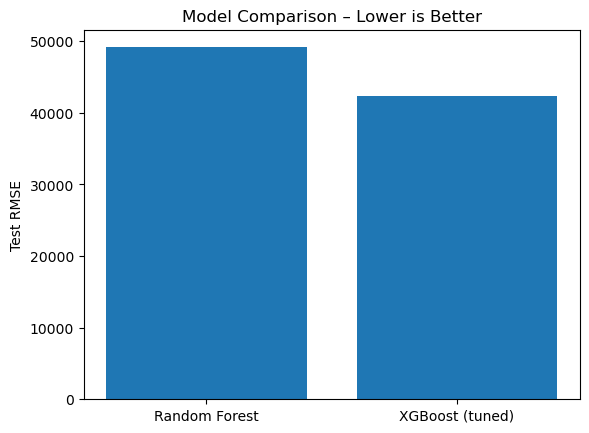

In [14]:
plt.bar(results["model"], results["test_rmse"])
plt.ylabel("Test RMSE")
plt.title("Model Comparison – Lower is Better")
plt.show()

### 7. Feature importance for XGBoost

In [15]:
ohe = best_xgb_pipeline.named_steps["preprocess"].named_transformers_["cat"]
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

all_feature_names = numeric_features + list(ohe_feature_names)

importances = best_xgb_pipeline.named_steps["model"].feature_importances_

xgb_importance = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

xgb_importance.head(20)


,feature,importance
3,City_Bangalore,0.148334
2,Bathroom,0.143492
13,Furnishing Status_Semi-Furnished,0.127583
8,City_Mumbai,0.121764
15,Tenant Preferred_Bachelors,0.099533
0,Size,0.091323
1,BHK,0.063231
16,Tenant Preferred_Bachelors/Family,0.035130
6,City_Hyderabad,0.033511
14,Furnishing Status_Unfurnished,0.030877


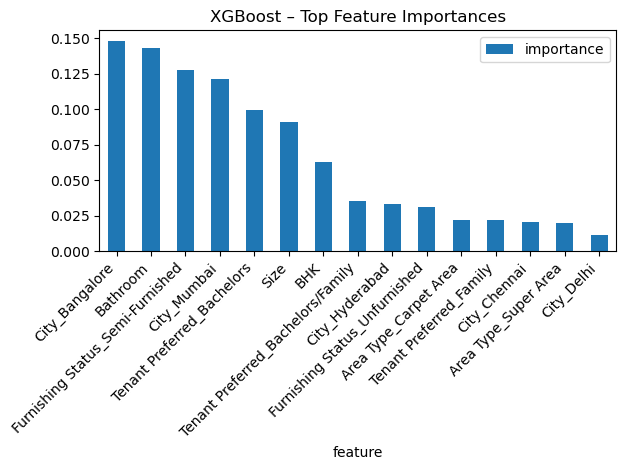

In [16]:
top_n = 15
xgb_importance.head(top_n).plot(
    x="feature",
    y="importance",
    kind="bar"
)
plt.title("XGBoost – Top Feature Importances")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Summary – Advanced Modeling

In this notebook I:

- Reused the **preprocessing pipeline** from the baseline model (numeric + categorical handling).
- Evaluated a **Random Forest** model using **5-fold cross-validation**.
- Built an **XGBoost** regression model and performed **hyperparameter tuning** with `RandomizedSearchCV`.
- Compared final performance of:
  - Baseline Random Forest
  - Tuned XGBoost model
- Analyzed **feature importance** for the tuned XGBoost model.

Key takeaways:

- Cross-validation provides a more robust estimate of model performance compared to a single train/test split.
- The tuned XGBoost model achieved **lower error** and **higher R²** than the baseline Random Forest (see comparison table).
- Important predictors include features such as **[ City, Bathroom, Size ]**, confirming the role of both property size and location-related variables.

In a production setting, next steps could include:

- Calibrating predictions and monitoring model drift over time.
- Adding regular **retraining** as new data arrives.
- Deploying the model as an API or integrating it into a pricing tool for a real estate business.
